# The LinearAntisymmetricCell user guide - part 2

Here we show how to use the LinearAntisymmetricCell with a variable step size.

In [1]:
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

from numpy.random import default_rng
rng = default_rng()

from larnn import LinearAntisymmetricCell
from larnn import utils

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

sns.set()
sns.set_palette("muted")
plt.rcParams["font.family"] = "serif"
plt.axis('scaled')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


%matplotlib notebook

## Example data
As an example, we use data from 200 simulations of a continuous stirred tank reactor (CSTR). The system has two inputs and two outputs. More details are availabl in Moe and Sterud 2021 (available in upcoming Proceedings of Machine Learning Research vol 144:1–11, 2021).

This simulated data is available in the folder `./example_data`. There are three versions of the simulated data. In the files named `high_res_{train/val/test}.csv`, the sample rate is 1 / second, while in the files named `static_eps_{train/val/test}.csv` the sample rate is 1 / 10 minutes. Lastly, in the files called `var_eps_{train/val/test}.csv`, the inputs and outputs are sampled anywhere between every 5 and 20 minutes.

Here we show how to learn from and make predictions with the unevenly sampled data.

In [2]:
datadir = './example_data'

input_cols = ['input_1', 'input_2']
output_cols = ['output_1', 'output_2']

input_dim = len(input_cols)
output_dim = len(output_cols)
steps = 10

df_train = pd.read_csv(os.path.join(datadir, f'variable_eps_train.csv'))
df_train.index = pd.TimedeltaIndex(df_train['t'], unit='s')
df_train.loc[:, 't'] = df_train['t'].values / 60

df_val = pd.read_csv(os.path.join(datadir, f'variable_eps_val.csv'))
df_val.index = pd.TimedeltaIndex(df_val['t'], unit='s')
df_val.loc[:, 't'] = df_val['t'].values / 60

# utils.prep_dataframe gives us rolling window versions of the inputs, outputs and step sizes.

trainx, trainy, trainsteps = utils.prep_dataframe(df_train, steps, input_cols, output_cols)
valx, valy, valsteps = utils.prep_dataframe(df_val, steps, input_cols, output_cols)

In [3]:
print(f'Input data shape: {trainx.shape}')
print(f'Output data shape: {trainy.shape}')
print(f'Step size data shape: {trainsteps.shape}')

Input data shape: (31659, 10, 2)
Output data shape: (31659, 2)
Step size data shape: (31659, 10, 1)


## Making the model

We make the model the same way as before, but now we pass `var_step_size=True` to `LinearAntisymmetricCell`, and we create an input for both the inputs and the step sizes.


In [4]:
units = 20
lr = 1e-4

input_input = tf.keras.layers.Input(shape=(steps, input_dim), batch_size=None)
step_size_input = tf.keras.layers.Input(shape=(steps, 1), batch_size=None)
model_input = (input_input, step_size_input)

larnn_cells = LinearAntisymmetricCell(units, var_step_size=True)
larnn_layer = tf.keras.layers.RNN(larnn_cells)
dense_layer = tf.keras.layers.Dense(units - 2, activation="relu")
output_layer = tf.keras.layers.Dense(output_dim, activation="linear")

larnn_out = larnn_layer(model_input)
dense_out = dense_layer(larnn_out)
model_output = output_layer(dense_out)

model = tf.keras.models.Model(model_input, model_output)
opt = tf.keras.optimizers.Adam(lr)
model.compile(optimizer=opt, loss='mse')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
rnn (RNN)                       (None, 20)           460         input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 18)           378         rnn[0][0]                    

In [5]:
epochs = 20
batch_size = 64

model.fit(x=[trainx, trainsteps],
          y=trainy,
          validation_data=([valx, valsteps], valy),
          epochs=epochs,
          verbose=1,
          batch_size=batch_size)

Train on 31659 samples, validate on 9035 samples
Epoch 1/20
31659/31659 [==============================] - 9s 285us/sample - loss: 0.0246 - val_loss: 0.0100
Epoch 2/20
31659/31659 [==============================] - 7s 216us/sample - loss: 0.0066 - val_loss: 0.0051
Epoch 3/20
31659/31659 [==============================] - 7s 219us/sample - loss: 0.0038 - val_loss: 0.0031
Epoch 4/20
31659/31659 [==============================] - 7s 220us/sample - loss: 0.0029 - val_loss: 0.0027
Epoch 5/20
31659/31659 [==============================] - 7s 218us/sample - loss: 0.0024 - val_loss: 0.0021
Epoch 6/20
31659/31659 [==============================] - 7s 211us/sample - loss: 0.0022 - val_loss: 0.0018
Epoch 7/20
31659/31659 [==============================] - 7s 218us/sample - loss: 0.0019 - val_loss: 0.0016
Epoch 8/20
31659/31659 [==============================] - 6s 203us/sample - loss: 0.0017 - val_loss: 0.0015
Epoch 9/20
31659/31659 [==============================] - 6s 205us/sample - loss: 0.001

## Making predictions every n minutes

Now we can make predictions exactly when we want to. Here, we make predictions every 2 minutes, even though new data is not available in another 5 or 20 minutes.

In [6]:
# We choose a random simulation file from the test data to visualize.

df_test = pd.read_csv(os.path.join(datadir, f'variable_eps_test.csv'))
file_number = np.random.choice(df_test['file_number'].unique())
df_test = df_test[df_test['file_number'] == file_number].copy()

every_n = 2


df_test.index = pd.TimedeltaIndex(df_test['t'], unit='s')
df_test.loc[:, 't'] = df_test['t'].values / 60

testx, testy, teststeps = utils.prep_dataframe(df_test, steps, input_cols, output_cols)

pred_times = df_test.loc[df_test.index[steps - 1:], 't']
npreds = np.ceil(teststeps[:, -1] / every_n).astype(int)

preds = pd.DataFrame(columns=['x1', 'x2', 'time', 'predtype'])

# Each iteration of this loop takes an input sequence and makes predictions
# 'every_n', '2*every_n', '3*every_n'... minutes into the future until
# a new datapoint is available
for i in range(0, testx.shape[0] - 1):
    timestart = pred_times.iloc[i]
    # The prediction step sizes to use
    predsteps = np.expand_dims(np.arange(every_n, npreds[i] + every_n + 1, every_n), -1)
    # For each of the input sequences we need the step sizes corresponding to the time
    # between each sample in the input sequence
    step_sizes = np.tile(teststeps[i], (predsteps.shape[0], 1, 1))
    # The last step size in each sequence is set to be the desired prediction step size
    step_sizes[:, -1] = predsteps
    
    input_seq = np.tile(testx[i], (predsteps.shape[0], 1, 1))
    pred_i = model.predict((input_seq, step_sizes))
    plottime = timestart + predsteps
    preds = preds.append(pd.DataFrame.from_dict(
        {'x1': pred_i[:, 0], 'x2': pred_i[:, 1], 'time': np.squeeze(plottime),
         'predtype': (predsteps.shape[0] - 1)*[0] + [1]}),
        ignore_index=True)


<IPython.core.display.Javascript object>


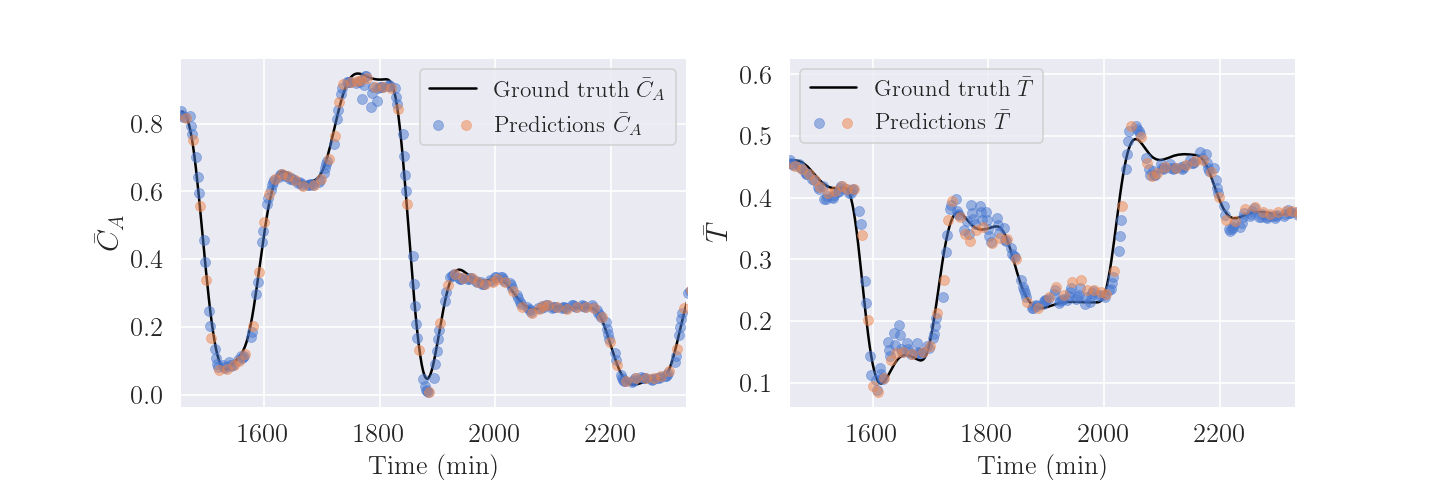

In [7]:
plotstart = df_test.loc[df_test.index[int(df_test.shape[0]*0.5)], 't']
plotstop = df_test.loc[df_test.index[int(df_test.shape[0]*0.8)], 't']


plotdf = pd.read_csv(os.path.join(datadir, f'high_res_test.csv'))
plotdf = plotdf[plotdf['file_number'] == file_number].copy()
plotdf.loc[:, 't'] = plotdf['t'].values / 60

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

sns.lineplot(data=plotdf, x='t', y=output_cols[0], ax=ax1, color='black', ci=None,
             label=r'Ground truth $\bar{C}_A$')
sns.lineplot(data=plotdf, x='t', y=output_cols[1], ax=ax2, color='black', ci=None,
             label=r'Ground truth $\bar{T}$')

sns.scatterplot(data=preds[preds['predtype']==0], x='time', y='x1',
                marker='o', ax=ax1, legend=False, alpha=0.5, **{'edgecolor': 'face'}, zorder=3,
                label=r'Predictions $\bar{C}_A$')
sns.scatterplot(data=preds[preds['predtype']==1], x='time', y='x1',
                marker='o', ax=ax1, legend=False, alpha=0.5, **{'edgecolor': 'face'}, zorder=3,
                label=r'Predictions $\bar{C}_A$')

sns.scatterplot(data=preds[preds['predtype']==0], x='time', y='x2',
                marker='o', ax=ax2, legend=False, alpha=0.5, **{'edgecolor': 'face'}, zorder=3,
                label=r'Predictions $\bar{T}$')
sns.scatterplot(data=preds[preds['predtype']==1], x='time', y='x2',
                marker='o', ax=ax2, legend=False, alpha=0.5, **{'edgecolor': 'face'}, zorder=3,
                label=r'Predictions $\bar{T}$')

ax1.set_xlabel(r'Time (min)', fontsize=16)
ax2.set_xlabel(r'Time (min)', fontsize=16)
ax1.set_ylabel(r'$\bar{C}_A$', fontsize=18)
ax2.set_ylabel(r'$\bar{T}$', fontsize=18)
ax1.set_xlim([plotstart, plotstop])
ax2.set_xlim([plotstart, plotstop])

ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)


ax1.legend([ax1.get_legend_handles_labels()[0][0], tuple(ax1.get_legend_handles_labels()[0][-2:])],
           [r'Ground truth $\bar{C}_A$', r'Predictions $\bar{C}_A$'], numpoints=1,
           handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=14)
ax2.legend([ax2.get_legend_handles_labels()[0][0], tuple(ax2.get_legend_handles_labels()[0][-2:])],
           [r'Ground truth $\bar{T}$', r'Predictions $\bar{T}$'], numpoints=1,
           handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=14)

fig.subplots_adjust(bottom=0.15)

In the plot above the orange dots indicate the first prediction made `every_n` minutes after new data has become available. The blue dots are predictions made `2*every_n`, `3*every_n`, etc. minutes after new data is available. As we see from the plot, the predictions reflect how far from the input sequence the prediction is made.